# 准备数据

In [24]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from sklearn.utils import shuffle
from tqdm import tqdm
import numpy as np
import pandas as pd
import math
import random
import json
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import h5py
%matplotlib inline
np.random.seed(2018)

* 将数据复制到'train\cat'，'train\dog'，'test\test'文件夹，用于flow_from_directory；

In [26]:
def clear_dir(path: str):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)

In [27]:
def ref_test_data():
    src_dir = 'test'
    des_dir = 'test'

    cur_path = os.getcwd()
    des_dir = des_dir + os.sep + 'test'
    clear_dir(des_dir)
    
    data_list = os.listdir(src_dir)
    for file_name in data_list:
        srcfile = cur_path + os.sep + src_dir +os.sep + file_name
        dstfile = des_dir + os.sep + file_name            
        if os.path.isfile(srcfile):
            shutil.copyfile(srcfile,dstfile)      #复制图片到指定目录        
    return


In [28]:
def ref_train_data(class_name: str):
    src_dir = 'train'
    des_dir = 'train'

    cur_path = os.getcwd()
    
    # clear dir
    if not os.path.exists(des_dir):
        os.mkdir(des_dir)
        
    des_dir = des_dir + os.sep + class_name
    clear_dir(des_dir)
    
    # ref raw data
    data_list = os.listdir(src_dir)

    for file_name in data_list:
        if file_name.startswith(class_name):
            srcfile = cur_path + os.sep + src_dir +os.sep + file_name
            dstfile = des_dir + os.sep + file_name            
            if os.path.isfile(srcfile):
                shutil.copyfile(srcfile,dstfile)      #复制图片到指定目录
    return

In [29]:
ref_train_data('cat')
ref_train_data('dog')
ref_test_data()

### 分割数据
* 随机抽取20%数据至"val"文件夹
* 剩余80%训练数据按1:9分为"pretrain"、"finetune"两部分

In [30]:
def random_sample_data(total_num: int, val_split=0.2, pretrain_split=0.1, seed=2018):
    val_num = round(total_num * val_split)
    train_num = total_num - val_num
    pretrain_num = round(pretrain_split * train_num)
    
    index_list = [i for i in range(total_num)]
    random.seed(seed)
    random.shuffle(index_list)
    
    return index_list[:pretrain_num], index_list[pretrain_num:train_num], index_list[train_num:]


In [31]:
def split_train_data(class_name: str, val_split=0.2, pretrain_split=0.1):
    src_dir = 'train' + os.sep + class_name + os.sep
    pretrain_dir = 'pretrain'
    finetune_dir = 'finetune'
    val_dir = 'val'
    cur_path = os.getcwd()

    file_list = os.listdir('train' + os.sep + class_name)

    # data split
    pretrain_index_list, finetune_index_list, val_index_list = \
    random_sample_data(len(file_list), val_split=val_split, pretrain_split=pretrain_split)

    # clear pretrain dir
    if not os.path.exists(pretrain_dir):
        os.mkdir(pretrain_dir)
        
    pretrain_dir = pretrain_dir + os.sep + class_name
    clear_dir(pretrain_dir)
    
    # clear finetune dir
    if not os.path.exists(finetune_dir):
        os.mkdir(finetune_dir)
        
    finetune_dir = finetune_dir + os.sep + class_name
    clear_dir(finetune_dir)
    
    # clear val dir
    if not os.path.exists(val_dir):
        os.mkdir(val_dir)
        
    val_dir = val_dir + os.sep + class_name
    clear_dir(val_dir)
    
    # ref data
    for i, file in enumerate(file_list):
        if i in pretrain_index_list:
            file_path = pretrain_dir + os.sep + file
        elif i in finetune_index_list:
            file_path = finetune_dir + os.sep + file
        else:
            file_path = val_dir + os.sep + file
            
        shutil.copyfile(src_dir + file, file_path)
        #os.symlink(os.readlink(src_dir + file), file_path)

    return


In [32]:
split_train_data('cat')
split_train_data('dog')        

### 验证:

In [33]:
def verify_data_split(class_name: str):
    split_file_list=['pretrain', 'finetune', 'val']
    total_file_list = []
    for file_list in split_file_list:
        total_file_list = total_file_list + os.listdir(file_list + os.sep + class_name)
    
    print(len(total_file_list))
    assert len(set(total_file_list)) == len(total_file_list)
    train_list = os.listdir('train' + os.sep + class_name)
    assert len(total_file_list) == len(train_list)
    

In [34]:
verify_data_split('dog')
verify_data_split('cat')

12500
12500


# 导出特征向量

In [35]:
def gen_feature(MODEL, model_name: str, input_size: tuple, pre_process_func, batch_size=64, 
                pretrain_dir='pretrain', finetune_dir='finetune', val_dir='val', test_dir='test'):
    
    x = Input((input_size[0], input_size[1], 3))
    x = Lambda(pre_process_func)(x)

    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    img_gen = ImageDataGenerator()
    
    pretrain_data_gen = img_gen.flow_from_directory(pretrain_dir, input_size, shuffle=False, batch_size=batch_size, class_mode='binary')
    finetune_data_gen = img_gen.flow_from_directory(finetune_dir, input_size, shuffle=False, batch_size=batch_size, class_mode='binary')
    val_data_gen = img_gen.flow_from_directory(val_dir, input_size, shuffle=False, batch_size=batch_size, class_mode='binary')
    test_data_gen = img_gen.flow_from_directory(test_dir, input_size, shuffle=False, batch_size=batch_size, class_mode=None)
   
    pretrain_feature = model.predict_generator(pretrain_data_gen, len(pretrain_data_gen), verbose=1)
    finetune_feature = model.predict_generator(finetune_data_gen, len(finetune_data_gen), verbose=1)
    val_feature = model.predict_generator(val_data_gen, len(val_data_gen), verbose=1)
    test_feature = model.predict_generator(test_data_gen, len(test_data_gen), verbose=1)
    
    
    h5_file = "feature_%s.h5"%model_name
    if os.path.isfile(h5_file):
        os.remove(h5_file)
    
    with h5py.File(h5_file) as h:
        h.create_dataset("pretrain", data=pretrain_feature)
        h.create_dataset("pretrain_label", data=pretrain_data_gen.classes)
        h.create_dataset("finetune", data=finetune_feature)
        h.create_dataset("finetune_label", data=finetune_data_gen.classes)
        h.create_dataset("val", data=val_feature)
        h.create_dataset("val_label", data=val_data_gen.classes)
        h.create_dataset("test", data=test_feature)        

In [36]:
gen_feature(InceptionV3, 'InceptionV3', (299, 299), pre_process_func=inception_v3.preprocess_input)

Found 2000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
196/196 [==============================] - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1:

In [37]:
gen_feature(Xception, 'Xception', (299, 299), pre_process_func=xception.preprocess_input, batch_size=64)

Found 2000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
196/196 [==============================] - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2:

In [38]:
gen_feature(InceptionResNetV2, 'InceptionResNetV2', (299, 299), pre_process_func=inception_resnet_v2.preprocess_input)

Found 2000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
196/196 [==============================] - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2:

In [42]:
#gen_feature(VGG19, 'VGG19', (299, 299), pre_process_func=vgg19.preprocess_input)

In [43]:
gen_feature(ResNet50, 'ResNet50', (299, 299), pre_process_func=resnet50.preprocess_input)

Found 2000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
196/196 [==============================] - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1:

In [44]:
def plot_history(history, model_name):
    # list all data in history
    # print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('%s accuracy'%model_name)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('%s loss'%model_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## 读取特征数据
* 使用80%数据作为训练集，20%数据作为验证集

In [45]:
def read_feature(model_name: str):
    h5_file = "feature_%s.h5"%model_name

    with h5py.File(h5_file, 'r') as h:
        X_pretrain = np.array(h['pretrain'])
        y_pretrain = np.array(h['pretrain_label'])
        X_finetune = np.array(h['finetune'])
        y_finetune = np.array(h['finetune_label'])
        X_val = np.array(h['val'])
        y_val = np.array(h['val_label'])
        X_test = np.array(h['test'])

    X_train = np.concatenate((X_pretrain, X_finetune), axis=0)
    y_train = np.concatenate((y_pretrain, y_finetune), axis=0)

    X_train, y_train = shuffle(X_train, y_train)
    
    return X_train, y_train, X_val, y_val, X_test


# 构建分类器

In [46]:
def build_model(input_shape, drop_prob: float, lr=1e-2, decay=0):
    input_tensor = Input(input_shape)
    x = Dropout(drop_prob)(input_tensor)
    x = Dense(1, activation='sigmoid', name='top_sigmoid')(x)
    model = Model(input_tensor, x)

    opt = optimizers.Adam(lr=lr, decay=decay)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

### InceptionV3

In [47]:
model_name = 'InceptionV3'
X_train, y_train, X_val, y_val, X_test = read_feature(model_name)
print(X_train.shape, X_val.shape)

(20000, 2048) (5000, 2048)


 * 调整参数

In [48]:
model = build_model(X_train.shape[1:], 0.5, lr=1e-3, decay=1e-6)

In [49]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
             ModelCheckpoint(filepath='top_model_%s.h5'%model_name, monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - ETA: 10:21 - loss: 0.7394 - acc: 0.57 - ETA: 1:06 - loss: 0.6050 - acc: 0.6719 - ETA: 33s - loss: 0.4873 - acc: 0.781 - ETA: 21s - loss: 0.4023 - acc: 0.83 - ETA: 15s - loss: 0.3443 - acc: 0.86 - ETA: 12s - loss: 0.3017 - acc: 0.89 - ETA: 9s - loss: 0.2706 - acc: 0.9053 - ETA: 7s - loss: 0.2446 - acc: 0.916 - ETA: 6s - loss: 0.2264 - acc: 0.924 - ETA: 5s - loss: 0.2102 - acc: 0.930 - ETA: 4s - loss: 0.1958 - acc: 0.936 - ETA: 3s - loss: 0.1841 - acc: 0.941 - ETA: 2s - loss: 0.1742 - acc: 0.945 - ETA: 2s - loss: 0.1652 - acc: 0.948 - ETA: 1s - loss: 0.1572 - acc: 0.951 - ETA: 1s - loss: 0.1508 - acc: 0.954 - ETA: 1s - loss: 0.1447 - acc: 0.956 - ETA: 0s - loss: 0.1385 - acc: 0.958 - ETA: 0s - loss: 0.1338 - acc: 0.960 - ETA: 0s - loss: 0.1293 - acc: 0.961 - 5s 273us/step - loss: 0.1268 - acc: 0.9625 - val_loss: 0.0359 - val_acc: 0.9928
Epoch 2/30
20000/20000 [======================

20000/20000 [==============================] - ETA: 1s - loss: 0.0064 - acc: 1.000 - ETA: 1s - loss: 0.0168 - acc: 0.996 - ETA: 1s - loss: 0.0169 - acc: 0.995 - ETA: 0s - loss: 0.0163 - acc: 0.995 - ETA: 0s - loss: 0.0177 - acc: 0.994 - ETA: 0s - loss: 0.0188 - acc: 0.993 - ETA: 0s - loss: 0.0186 - acc: 0.994 - ETA: 0s - loss: 0.0202 - acc: 0.993 - ETA: 0s - loss: 0.0205 - acc: 0.993 - ETA: 0s - loss: 0.0209 - acc: 0.993 - ETA: 0s - loss: 0.0219 - acc: 0.993 - ETA: 0s - loss: 0.0217 - acc: 0.993 - ETA: 0s - loss: 0.0220 - acc: 0.993 - ETA: 0s - loss: 0.0221 - acc: 0.993 - ETA: 0s - loss: 0.0214 - acc: 0.993 - ETA: 0s - loss: 0.0218 - acc: 0.993 - ETA: 0s - loss: 0.0219 - acc: 0.993 - ETA: 0s - loss: 0.0224 - acc: 0.993 - ETA: 0s - loss: 0.0225 - acc: 0.992 - ETA: 0s - loss: 0.0220 - acc: 0.993 - ETA: 0s - loss: 0.0223 - acc: 0.993 - 1s 65us/step - loss: 0.0223 - acc: 0.9931 - val_loss: 0.0165 - val_acc: 0.9944
Epoch 10/30
20000/20000 [==============================] - ETA: 1s - loss: 0

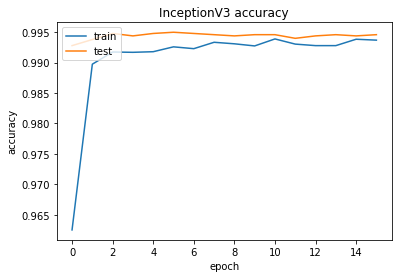

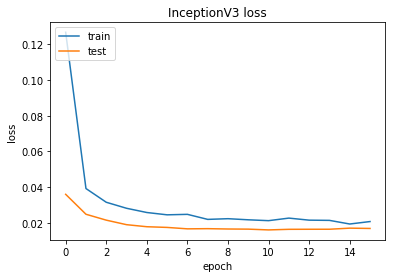

In [50]:
plot_history(history, model_name)

### Xception

In [51]:
model_name = 'Xception'
X_train, y_train, X_val, y_val, X_test = read_feature(model_name)
print(X_train.shape, X_val.shape)

(20000, 2048) (5000, 2048)


* 调整参数

In [52]:
model = build_model(X_train.shape[1:], 0.6, lr=1e-3, decay=1e-6)

In [53]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
             ModelCheckpoint(filepath='top_model_%s.h5'%model_name, monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - ETA: 11:16 - loss: 0.7037 - acc: 0.56 - ETA: 1:21 - loss: 0.5970 - acc: 0.6895 - ETA: 39s - loss: 0.5062 - acc: 0.802 - ETA: 24s - loss: 0.4373 - acc: 0.85 - ETA: 17s - loss: 0.3832 - acc: 0.88 - ETA: 13s - loss: 0.3469 - acc: 0.90 - ETA: 10s - loss: 0.3125 - acc: 0.91 - ETA: 8s - loss: 0.2853 - acc: 0.9263 - ETA: 7s - loss: 0.2650 - acc: 0.933 - ETA: 5s - loss: 0.2458 - acc: 0.939 - ETA: 5s - loss: 0.2315 - acc: 0.944 - ETA: 4s - loss: 0.2192 - acc: 0.947 - ETA: 3s - loss: 0.2078 - acc: 0.951 - ETA: 2s - loss: 0.1968 - acc: 0.954 - ETA: 2s - loss: 0.1886 - acc: 0.956 - ETA: 1s - loss: 0.1804 - acc: 0.958 - ETA: 1s - loss: 0.1729 - acc: 0.960 - ETA: 1s - loss: 0.1660 - acc: 0.962 - ETA: 0s - loss: 0.1601 - acc: 0.963 - ETA: 0s - loss: 0.1550 - acc: 0.965 - ETA: 0s - loss: 0.1498 - acc: 0.966 - 6s 294us/step - loss: 0.1484 - acc: 0.9669 - val_loss: 0.0469 - val_acc: 0.9922
Epoch 2/

20000/20000 [==============================] - ETA: 1s - loss: 0.0057 - acc: 1.000 - ETA: 1s - loss: 0.0215 - acc: 0.992 - ETA: 1s - loss: 0.0185 - acc: 0.993 - ETA: 1s - loss: 0.0203 - acc: 0.992 - ETA: 0s - loss: 0.0303 - acc: 0.990 - ETA: 0s - loss: 0.0293 - acc: 0.990 - ETA: 0s - loss: 0.0293 - acc: 0.990 - ETA: 0s - loss: 0.0280 - acc: 0.990 - ETA: 0s - loss: 0.0263 - acc: 0.991 - ETA: 0s - loss: 0.0248 - acc: 0.992 - ETA: 0s - loss: 0.0236 - acc: 0.992 - ETA: 0s - loss: 0.0240 - acc: 0.992 - ETA: 0s - loss: 0.0240 - acc: 0.992 - ETA: 0s - loss: 0.0227 - acc: 0.993 - ETA: 0s - loss: 0.0225 - acc: 0.993 - ETA: 0s - loss: 0.0223 - acc: 0.993 - ETA: 0s - loss: 0.0229 - acc: 0.993 - ETA: 0s - loss: 0.0230 - acc: 0.993 - ETA: 0s - loss: 0.0228 - acc: 0.993 - ETA: 0s - loss: 0.0225 - acc: 0.993 - ETA: 0s - loss: 0.0221 - acc: 0.993 - 1s 63us/step - loss: 0.0220 - acc: 0.9935 - val_loss: 0.0152 - val_acc: 0.9952
Epoch 10/30
20000/20000 [==============================] - ETA: 1s - loss: 0

20000/20000 [==============================] - ETA: 1s - loss: 0.0526 - acc: 0.992 - ETA: 1s - loss: 0.0263 - acc: 0.993 - ETA: 0s - loss: 0.0213 - acc: 0.992 - ETA: 0s - loss: 0.0220 - acc: 0.992 - ETA: 0s - loss: 0.0211 - acc: 0.992 - ETA: 0s - loss: 0.0185 - acc: 0.993 - ETA: 0s - loss: 0.0177 - acc: 0.994 - ETA: 0s - loss: 0.0173 - acc: 0.994 - ETA: 0s - loss: 0.0188 - acc: 0.994 - ETA: 0s - loss: 0.0180 - acc: 0.994 - ETA: 0s - loss: 0.0195 - acc: 0.994 - ETA: 0s - loss: 0.0193 - acc: 0.994 - ETA: 0s - loss: 0.0192 - acc: 0.994 - ETA: 0s - loss: 0.0193 - acc: 0.993 - ETA: 0s - loss: 0.0186 - acc: 0.994 - ETA: 0s - loss: 0.0192 - acc: 0.993 - ETA: 0s - loss: 0.0195 - acc: 0.993 - ETA: 0s - loss: 0.0193 - acc: 0.993 - ETA: 0s - loss: 0.0193 - acc: 0.994 - ETA: 0s - loss: 0.0190 - acc: 0.994 - 1s 60us/step - loss: 0.0189 - acc: 0.9940 - val_loss: 0.0135 - val_acc: 0.9958
Epoch 19/30
20000/20000 [==============================] - ETA: 1s - loss: 0.0058 - acc: 1.000 - ETA: 0s - loss: 0

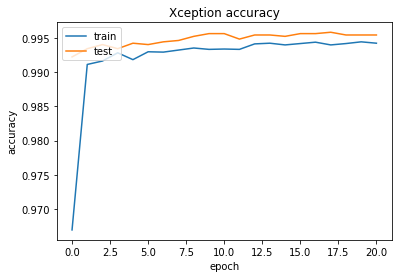

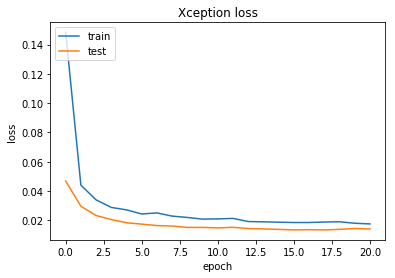

In [54]:
plot_history(history, model_name)

### InceptionResNetV2

In [55]:
model_name = 'InceptionResNetV2'
X_train, y_train, X_val, y_val, X_test = read_feature(model_name)
print(X_train.shape, X_val.shape)

(20000, 1536) (5000, 1536)


* 调整参数

In [56]:
model = build_model(X_train.shape[1:], 0.2, lr=1e-3, decay=1e-6)

In [57]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
             ModelCheckpoint(filepath='top_model_%s.h5'%model_name, monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - ETA: 10:36 - loss: 0.6797 - acc: 0.60 - ETA: 1:16 - loss: 0.5675 - acc: 0.7490 - ETA: 39s - loss: 0.4619 - acc: 0.844 - ETA: 24s - loss: 0.3746 - acc: 0.89 - ETA: 17s - loss: 0.3167 - acc: 0.91 - ETA: 13s - loss: 0.2811 - acc: 0.92 - ETA: 10s - loss: 0.2487 - acc: 0.93 - ETA: 8s - loss: 0.2250 - acc: 0.9470 - ETA: 7s - loss: 0.2090 - acc: 0.951 - ETA: 5s - loss: 0.1922 - acc: 0.956 - ETA: 4s - loss: 0.1779 - acc: 0.959 - ETA: 4s - loss: 0.1679 - acc: 0.962 - ETA: 3s - loss: 0.1590 - acc: 0.964 - ETA: 2s - loss: 0.1510 - acc: 0.966 - ETA: 2s - loss: 0.1442 - acc: 0.968 - ETA: 1s - loss: 0.1379 - acc: 0.969 - ETA: 1s - loss: 0.1317 - acc: 0.970 - ETA: 1s - loss: 0.1271 - acc: 0.972 - ETA: 0s - loss: 0.1231 - acc: 0.972 - ETA: 0s - loss: 0.1184 - acc: 0.974 - ETA: 0s - loss: 0.1146 - acc: 0.974 - 6s 283us/step - loss: 0.1120 - acc: 0.9755 - val_loss: 0.0362 - val_acc: 0.9932
Epoch 2/

20000/20000 [==============================] - ETA: 1s - loss: 0.0032 - acc: 1.000 - ETA: 1s - loss: 0.0204 - acc: 0.996 - ETA: 1s - loss: 0.0152 - acc: 0.996 - ETA: 1s - loss: 0.0180 - acc: 0.995 - ETA: 0s - loss: 0.0178 - acc: 0.995 - ETA: 0s - loss: 0.0179 - acc: 0.994 - ETA: 0s - loss: 0.0165 - acc: 0.995 - ETA: 0s - loss: 0.0160 - acc: 0.995 - ETA: 0s - loss: 0.0153 - acc: 0.995 - ETA: 0s - loss: 0.0162 - acc: 0.995 - ETA: 0s - loss: 0.0154 - acc: 0.995 - ETA: 0s - loss: 0.0156 - acc: 0.995 - ETA: 0s - loss: 0.0152 - acc: 0.995 - ETA: 0s - loss: 0.0161 - acc: 0.995 - ETA: 0s - loss: 0.0158 - acc: 0.995 - ETA: 0s - loss: 0.0153 - acc: 0.996 - ETA: 0s - loss: 0.0167 - acc: 0.995 - ETA: 0s - loss: 0.0167 - acc: 0.995 - ETA: 0s - loss: 0.0168 - acc: 0.995 - ETA: 0s - loss: 0.0167 - acc: 0.995 - ETA: 0s - loss: 0.0175 - acc: 0.995 - 1s 64us/step - loss: 0.0171 - acc: 0.9954 - val_loss: 0.0123 - val_acc: 0.9954
Epoch 10/30
20000/20000 [==============================] - ETA: 1s - loss: 0

Epoch 18/30
20000/20000 [==============================] - ETA: 1s - loss: 0.0124 - acc: 0.992 - ETA: 1s - loss: 0.0099 - acc: 0.996 - ETA: 1s - loss: 0.0103 - acc: 0.996 - ETA: 0s - loss: 0.0137 - acc: 0.996 - ETA: 0s - loss: 0.0146 - acc: 0.996 - ETA: 0s - loss: 0.0176 - acc: 0.995 - ETA: 0s - loss: 0.0163 - acc: 0.995 - ETA: 0s - loss: 0.0152 - acc: 0.996 - ETA: 0s - loss: 0.0147 - acc: 0.996 - ETA: 0s - loss: 0.0150 - acc: 0.995 - ETA: 0s - loss: 0.0145 - acc: 0.996 - ETA: 0s - loss: 0.0144 - acc: 0.996 - ETA: 0s - loss: 0.0138 - acc: 0.996 - ETA: 0s - loss: 0.0138 - acc: 0.996 - ETA: 0s - loss: 0.0135 - acc: 0.996 - ETA: 0s - loss: 0.0136 - acc: 0.996 - ETA: 0s - loss: 0.0139 - acc: 0.996 - ETA: 0s - loss: 0.0142 - acc: 0.996 - ETA: 0s - loss: 0.0139 - acc: 0.996 - ETA: 0s - loss: 0.0142 - acc: 0.996 - 1s 61us/step - loss: 0.0141 - acc: 0.9961 - val_loss: 0.0118 - val_acc: 0.9956
Epoch 19/30
20000/20000 [==============================] - ETA: 1s - loss: 0.0050 - acc: 1.000 - ETA: 

Epoch 27/30
20000/20000 [==============================] - ETA: 1s - loss: 0.0076 - acc: 1.000 - ETA: 1s - loss: 0.0076 - acc: 0.998 - ETA: 0s - loss: 0.0115 - acc: 0.997 - ETA: 0s - loss: 0.0125 - acc: 0.995 - ETA: 0s - loss: 0.0121 - acc: 0.996 - ETA: 0s - loss: 0.0141 - acc: 0.996 - ETA: 0s - loss: 0.0137 - acc: 0.996 - ETA: 0s - loss: 0.0132 - acc: 0.996 - ETA: 0s - loss: 0.0140 - acc: 0.996 - ETA: 0s - loss: 0.0143 - acc: 0.996 - ETA: 0s - loss: 0.0149 - acc: 0.995 - ETA: 0s - loss: 0.0142 - acc: 0.996 - ETA: 0s - loss: 0.0141 - acc: 0.996 - ETA: 0s - loss: 0.0138 - acc: 0.996 - ETA: 0s - loss: 0.0132 - acc: 0.996 - ETA: 0s - loss: 0.0132 - acc: 0.996 - ETA: 0s - loss: 0.0129 - acc: 0.996 - ETA: 0s - loss: 0.0129 - acc: 0.996 - ETA: 0s - loss: 0.0127 - acc: 0.996 - ETA: 0s - loss: 0.0128 - acc: 0.996 - 1s 61us/step - loss: 0.0126 - acc: 0.9965 - val_loss: 0.0105 - val_acc: 0.9962
Epoch 28/30
20000/20000 [==============================] - ETA: 1s - loss: 0.0035 - acc: 1.000 - ETA: 

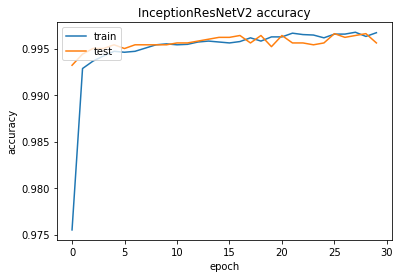

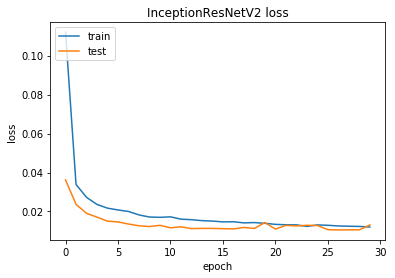

In [58]:
plot_history(history, model_name)

In [59]:
model_name = 'ResNet50'
X_train, y_train, X_val, y_val, X_test = read_feature(model_name)
print(X_train.shape, X_val.shape)

(20000, 2048) (5000, 2048)


In [60]:
model = build_model(X_train.shape[1:], 0.2, lr=1e-3, decay=1e-6)

In [61]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
             ModelCheckpoint(filepath='top_model_%s.h5'%model_name, monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - ETA: 10:20 - loss: 0.6357 - acc: 0.67 - ETA: 1:15 - loss: 0.4567 - acc: 0.8154 - ETA: 35s - loss: 0.3405 - acc: 0.876 - ETA: 22s - loss: 0.2757 - acc: 0.90 - ETA: 16s - loss: 0.2334 - acc: 0.91 - ETA: 12s - loss: 0.2030 - acc: 0.93 - ETA: 9s - loss: 0.1798 - acc: 0.9401 - ETA: 7s - loss: 0.1659 - acc: 0.944 - ETA: 6s - loss: 0.1534 - acc: 0.948 - ETA: 5s - loss: 0.1432 - acc: 0.951 - ETA: 4s - loss: 0.1346 - acc: 0.955 - ETA: 3s - loss: 0.1294 - acc: 0.956 - ETA: 2s - loss: 0.1230 - acc: 0.958 - ETA: 2s - loss: 0.1177 - acc: 0.960 - ETA: 1s - loss: 0.1128 - acc: 0.962 - ETA: 1s - loss: 0.1103 - acc: 0.963 - ETA: 1s - loss: 0.1063 - acc: 0.964 - ETA: 0s - loss: 0.1033 - acc: 0.965 - ETA: 0s - loss: 0.1003 - acc: 0.966 - ETA: 0s - loss: 0.0980 - acc: 0.967 - 5s 274us/step - loss: 0.0957 - acc: 0.9682 - val_loss: 0.0414 - val_acc: 0.9862
Epoch 2/30
20000/20000 [======================

20000/20000 [==============================] - ETA: 1s - loss: 0.0147 - acc: 0.992 - ETA: 0s - loss: 0.0205 - acc: 0.992 - ETA: 0s - loss: 0.0244 - acc: 0.989 - ETA: 0s - loss: 0.0243 - acc: 0.989 - ETA: 0s - loss: 0.0223 - acc: 0.990 - ETA: 0s - loss: 0.0227 - acc: 0.991 - ETA: 0s - loss: 0.0225 - acc: 0.992 - ETA: 0s - loss: 0.0224 - acc: 0.992 - ETA: 0s - loss: 0.0219 - acc: 0.992 - ETA: 0s - loss: 0.0211 - acc: 0.992 - ETA: 0s - loss: 0.0219 - acc: 0.992 - ETA: 0s - loss: 0.0217 - acc: 0.992 - ETA: 0s - loss: 0.0210 - acc: 0.992 - ETA: 0s - loss: 0.0211 - acc: 0.992 - ETA: 0s - loss: 0.0211 - acc: 0.992 - ETA: 0s - loss: 0.0216 - acc: 0.992 - ETA: 0s - loss: 0.0220 - acc: 0.992 - ETA: 0s - loss: 0.0220 - acc: 0.992 - ETA: 0s - loss: 0.0218 - acc: 0.992 - ETA: 0s - loss: 0.0217 - acc: 0.992 - 1s 60us/step - loss: 0.0220 - acc: 0.9922 - val_loss: 0.0287 - val_acc: 0.9892
Epoch 11/30
20000/20000 [==============================] - ETA: 1s - loss: 0.0124 - acc: 1.000 - ETA: 1s - loss: 0

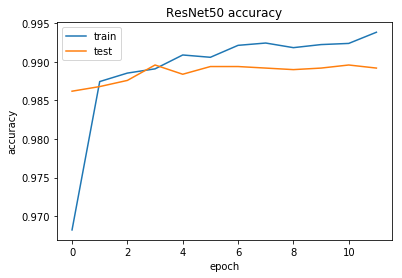

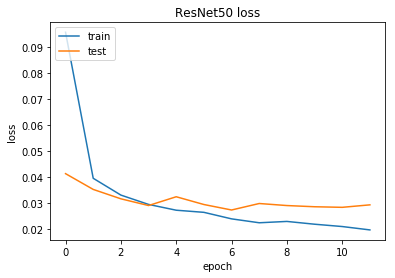

In [62]:
plot_history(history, model_name)

## 预测测试集

In [63]:
model.load_weights('top_model_%s.h5'%model_name)

In [64]:
y_pred = model.predict(X_test, verbose=1)

12500/12500 [==============================] - ETA: 11:4 - ETA: 49s  - ETA: 26 - ETA: 18 - ETA: 13 - ETA: 10 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 273us/step


In [65]:
y_pred_clip = y_pred.clip(min=0.005, max=0.995)

In [66]:
df = pd.read_csv("sampleSubmission.csv")

image_size = (299, 299)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test", image_size, shuffle=False, 
                                         batch_size=64, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind(os.sep)+1:fname.rfind('.')])
    df.loc[index-1, ['label']] = y_pred_clip[i]

df.to_csv('pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


# 多模型融合

In [67]:
def plot_history_multi(history):
    # list all data in history
    # print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## 读取特征数据
* 使用80%数据作为训练集，20%数据作为验证集

In [72]:
def read_feature_multi():
    h5_filelist = ["feature_Xception.h5", "feature_InceptionV3.h5", "feature_InceptionResNetV2.h5", "feature_ResNet50.h5"]

    X_train = []
    X_test = []
    X_val = []
    X_test = []

    for filename in h5_filelist:
        with h5py.File(filename, 'r') as h:
            X_pretrain = np.array(h['pretrain'])
            y_pretrain = np.array(h['pretrain_label'])
            X_finetune = np.array(h['finetune'])
            y_finetune = np.array(h['finetune_label'])
            y_val = np.array(h['val_label'])
            X_val.append(np.array(h['val']))
            X_test.append(np.array(h['test']))
            
            X_train.append(np.concatenate((X_pretrain, X_finetune), axis=0))
            y_train = np.concatenate((y_pretrain, y_finetune), axis=0)

    X_train = np.concatenate(X_train, axis=1)
    X_val = np.concatenate(X_val, axis=1)
    X_test = np.concatenate(X_test, axis=1)

    X_train, y_train = shuffle(X_train, y_train)
    
    return X_train, y_train, X_val, y_val, X_test


In [73]:
X_train, y_train, X_val, y_val, X_test = read_feature_multi()
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape)

(20000, 7680) (20000,) (5000, 7680) (5000,) (12500, 7680)


## 构建分类器

In [74]:
def build_model_multi(input_shape, drop_prob: float, lr=1e-3, decay=1e-6):
    input_tensor = Input(input_shape)
    x = Dropout(drop_prob)(input_tensor)
    x = Dense(1, activation='sigmoid', name='top_sigmoid')(x)
    model = Model(input_tensor, x)

    opt = optimizers.Adam(lr=lr, decay=decay)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

* 调整参数

In [75]:
model = build_model_multi(X_train.shape[1:], 0.5, lr=1e-3, decay=1e-6)

In [76]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
             ModelCheckpoint(filepath='top_multimodel.h5', monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=128, epochs=30, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - ETA: 10:38 - loss: 0.7691 - acc: 0.50 - ETA: 1:44 - loss: 0.4930 - acc: 0.7734 - ETA: 55s - loss: 0.3508 - acc: 0.856 - ETA: 37s - loss: 0.2625 - acc: 0.89 - ETA: 27s - loss: 0.2144 - acc: 0.91 - ETA: 22s - loss: 0.1798 - acc: 0.93 - ETA: 17s - loss: 0.1567 - acc: 0.94 - ETA: 15s - loss: 0.1393 - acc: 0.94 - ETA: 12s - loss: 0.1287 - acc: 0.95 - ETA: 11s - loss: 0.1180 - acc: 0.95 - ETA: 9s - loss: 0.1089 - acc: 0.9617 - ETA: 8s - loss: 0.1025 - acc: 0.963 - ETA: 7s - loss: 0.0964 - acc: 0.965 - ETA: 6s - loss: 0.0907 - acc: 0.968 - ETA: 5s - loss: 0.0862 - acc: 0.969 - ETA: 5s - loss: 0.0823 - acc: 0.970 - ETA: 4s - loss: 0.0780 - acc: 0.972 - ETA: 4s - loss: 0.0743 - acc: 0.974 - ETA: 3s - loss: 0.0707 - acc: 0.975 - ETA: 3s - loss: 0.0682 - acc: 0.976 - ETA: 2s - loss: 0.0665 - acc: 0.977 - ETA: 2s - loss: 0.0643 - acc: 0.978 - ETA: 2s - loss: 0.0622 - acc: 0.978 - ETA: 1s - lo

Epoch 7/30
20000/20000 [==============================] - ETA: 1s - loss: 0.0056 - acc: 1.000 - ETA: 1s - loss: 0.0107 - acc: 0.997 - ETA: 1s - loss: 0.0157 - acc: 0.995 - ETA: 1s - loss: 0.0124 - acc: 0.996 - ETA: 1s - loss: 0.0130 - acc: 0.996 - ETA: 1s - loss: 0.0123 - acc: 0.996 - ETA: 1s - loss: 0.0117 - acc: 0.996 - ETA: 1s - loss: 0.0105 - acc: 0.996 - ETA: 1s - loss: 0.0102 - acc: 0.996 - ETA: 1s - loss: 0.0101 - acc: 0.996 - ETA: 1s - loss: 0.0105 - acc: 0.996 - ETA: 1s - loss: 0.0107 - acc: 0.996 - ETA: 1s - loss: 0.0100 - acc: 0.996 - ETA: 0s - loss: 0.0097 - acc: 0.996 - ETA: 0s - loss: 0.0093 - acc: 0.996 - ETA: 0s - loss: 0.0091 - acc: 0.996 - ETA: 0s - loss: 0.0088 - acc: 0.996 - ETA: 0s - loss: 0.0085 - acc: 0.997 - ETA: 0s - loss: 0.0085 - acc: 0.997 - ETA: 0s - loss: 0.0088 - acc: 0.997 - ETA: 0s - loss: 0.0085 - acc: 0.997 - ETA: 0s - loss: 0.0087 - acc: 0.997 - ETA: 0s - loss: 0.0084 - acc: 0.997 - ETA: 0s - loss: 0.0085 - acc: 0.997 - ETA: 0s - loss: 0.0088 - acc: 

20000/20000 [==============================] - ETA: 1s - loss: 0.0022 - acc: 1.000 - ETA: 1s - loss: 0.0081 - acc: 0.998 - ETA: 1s - loss: 0.0071 - acc: 0.998 - ETA: 1s - loss: 0.0077 - acc: 0.997 - ETA: 1s - loss: 0.0082 - acc: 0.997 - ETA: 1s - loss: 0.0071 - acc: 0.997 - ETA: 1s - loss: 0.0070 - acc: 0.997 - ETA: 1s - loss: 0.0076 - acc: 0.997 - ETA: 1s - loss: 0.0070 - acc: 0.997 - ETA: 1s - loss: 0.0065 - acc: 0.997 - ETA: 1s - loss: 0.0067 - acc: 0.997 - ETA: 1s - loss: 0.0071 - acc: 0.997 - ETA: 1s - loss: 0.0071 - acc: 0.997 - ETA: 1s - loss: 0.0069 - acc: 0.997 - ETA: 1s - loss: 0.0067 - acc: 0.997 - ETA: 1s - loss: 0.0065 - acc: 0.997 - ETA: 0s - loss: 0.0065 - acc: 0.997 - ETA: 0s - loss: 0.0063 - acc: 0.997 - ETA: 0s - loss: 0.0063 - acc: 0.997 - ETA: 0s - loss: 0.0071 - acc: 0.997 - ETA: 0s - loss: 0.0072 - acc: 0.997 - ETA: 0s - loss: 0.0070 - acc: 0.997 - ETA: 0s - loss: 0.0067 - acc: 0.997 - ETA: 0s - loss: 0.0066 - acc: 0.997 - ETA: 0s - loss: 0.0064 - acc: 0.997 - ETA

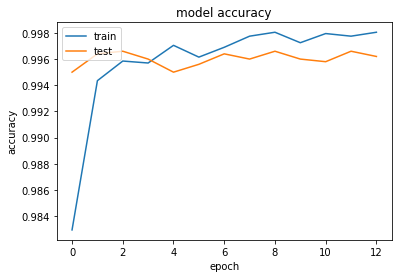

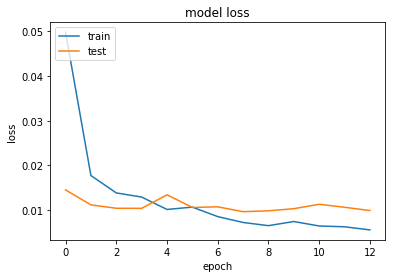

In [77]:
plot_history_multi(history)

## 预测测试集

In [79]:
model.load_weights('top_multimodel.h5')

In [80]:
y_pred = model.predict(X_test, verbose=1)

12500/12500 [==============================] - ETA: 12:4 - ETA: 1:2 - ETA: 40s - ETA: 27 - ETA: 20 - ETA: 16 - ETA: 14 - ETA: 12 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 339us/step


In [81]:
y_pred_clip = y_pred.clip(min=0.005, max=0.995)

In [82]:
df = pd.read_csv("sampleSubmission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test", (299, 299), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('\\')+1:fname.rfind('.')])
    df.loc[index-1, ['label']] = y_pred_clip[i]

df.to_csv('pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
